In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
%reload_ext Cython
import multiprocessing as mp

basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

app_train = pd.read_csv(os.path.join(basepath, 'data/raw/application_train.csv.zip'))
app_test  = pd.read_csv(os.path.join(basepath, 'data/raw/application_test.csv.zip'))

prev_app  = pd.read_csv(os.path.join(basepath, 'data/raw/previous_application.csv.zip'))

CPU times: user 15.8 s, sys: 736 ms, total: 16.6 s
Wall time: 17.3 s


In [47]:
%%time

tr = app_train.loc[:, ['SK_ID_CURR']].merge(prev_app.loc[:, ['SK_ID_CURR', 'DAYS_DECISION']],
                                       on='SK_ID_CURR',
                                       how='left'
                                      )

te = app_test.loc[:, ['SK_ID_CURR']].merge(prev_app.loc[:, ['SK_ID_CURR', 'DAYS_DECISION']],
                                           on='SK_ID_CURR',
                                           how='left'
                                          )

CPU times: user 516 ms, sys: 0 ns, total: 516 ms
Wall time: 519 ms


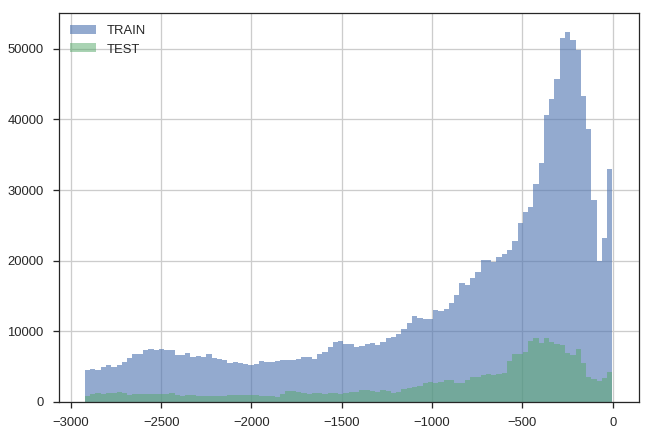

In [50]:
tr.DAYS_DECISION.hist(bins=100, alpha=.6, label='TRAIN')
te.DAYS_DECISION.hist(bins=100, alpha=.5, label='TEST')
plt.legend(loc='best');

In [4]:
%%time

tr = app_train.loc[:, ['SK_ID_CURR', 'AMT_CREDIT']].merge(prev_app.loc[:, ['SK_ID_CURR', 'DAYS_DECISION', 'AMT_CREDIT']],
                                                          on='SK_ID_CURR',
                                                          how='left',
                                                          suffixes=('_curr', '_prev')
                               )

CPU times: user 366 ms, sys: 0 ns, total: 366 ms
Wall time: 369 ms


In [9]:
def f(x):
    return x.sort_values(by='DAYS_DECISION', ascending=False).iloc[0]

res = tr.groupby('SK_ID_CURR').apply(f)

In [11]:
rres = res.AMT_CREDIT_curr - res.AMT_CREDIT_prev
rres = app_train.SK_ID_CURR.map(rres)

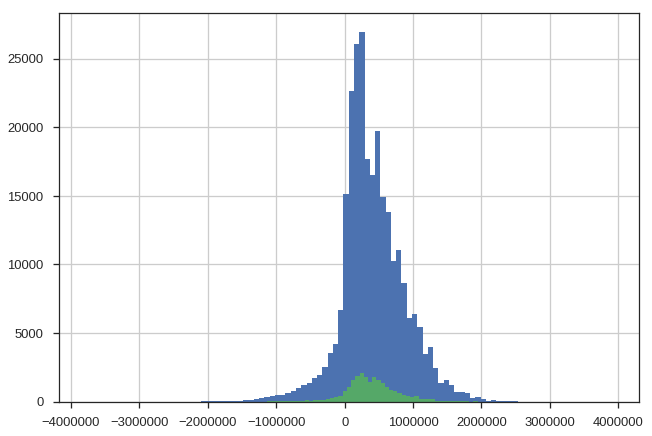

In [15]:
rres[(app_train.TARGET == 0)].hist(bins=100)
rres[(app_train.TARGET == 1)].hist(bins=100);

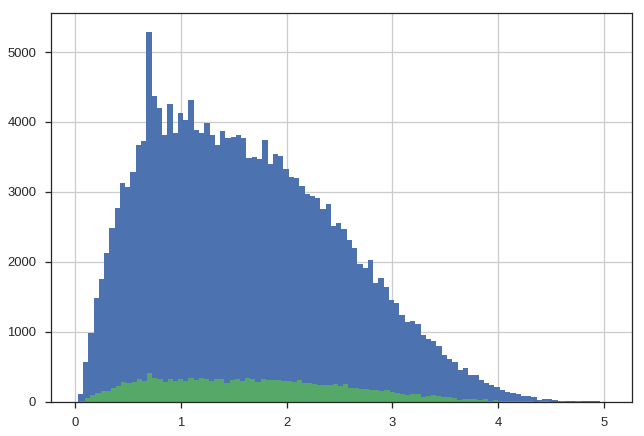

In [20]:
rres = (res.AMT_CREDIT_curr / res.AMT_CREDIT_prev).replace([np.inf, -np.inf], np.nan)
rres = app_train.SK_ID_CURR.map(rres)

rres[app_train.TARGET == 0].map(lambda x: np.log(x + 1)).hist(bins=100)
rres[app_train.TARGET == 1].map(lambda x: np.log(x + 1)).hist(bins=100);

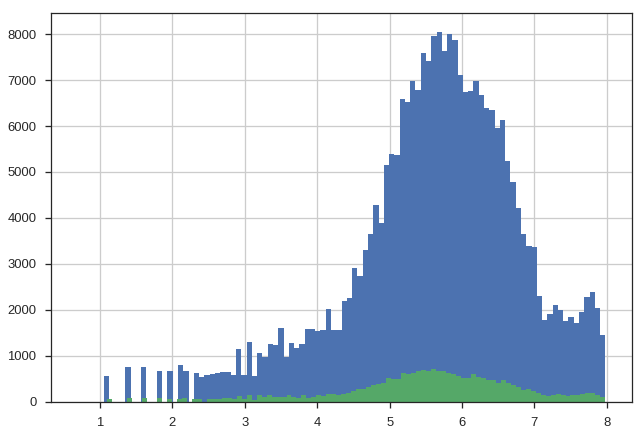

In [42]:
(-res[(app_train.TARGET == 0)]).map(np.log1p).hist(bins=100)
(-res[(app_train.TARGET == 1)]).map(np.log1p).hist(bins=100);

In [23]:
23221 / (255011 + 23221)

0.08345912763449208

In [21]:
pd.crosstab(app_train.NAME_CONTRACT_TYPE, app_train.TARGET)

TARGET,0,1
NAME_CONTRACT_TYPE,,
Cash loans,255011,23221
Revolving loans,27675,1604
